In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Вспомогательные функции

In [2]:
def plot_2d_function(f, N=100, x1_range=[-1, 1], x2_range=[-1, 1]):

    # Generate grid
    box = 0.6
    x1 = np.linspace(x1_range[0], x1_range[1], N)
    x2 = np.linspace(x2_range[0], x2_range[1], N)

    x1_grid, x2_grid = np.meshgrid(x1, x2)
    f_grid = f([x1_grid, x2_grid])

    plt.figure(figsize=(11, 6))
    #plt.contourf(x1, x2, f_grid, levels=np.linspace(-0.1, 1.01, 25))
    plt.contourf(x1, x2, f_grid, levels=25)
    plt.colorbar()

    plt.xlabel('X1', size=14)
    plt.xticks(size=14)

    plt.ylabel('X2', size=14)
    plt.yticks(size=14)

    plt.xlim(x1_range[0], x1_range[1])
    plt.ylim(x2_range[0], x2_range[1])
    
def add_opt_path(x_iters, label="Gradient descent", color="0", scatter=1):
    if scatter:
        plt.scatter(x_iters[:, 0], x_iters[:, 1], color=color, linewidth=2)
    plt.plot(x_iters[:, 0], x_iters[:, 1], color=color, linewidth=2, label=label)

In [3]:
from scipy.optimize import minimize

def alpha_search(f, x_curr, p):
    fun = lambda alpha: f(x_curr - alpha * p)
    res = minimize(fun, [0], method='Nelder-Mead')
    return res.x[0]

# Пример 1

Рассмотраим функцию двух переменных $x_1$ и $x_2$:

$$
f(x) = x_1^2 + x_2^4 + x_1 x_2
$$

Давайте найдем минимум этой функции.

In [4]:
# Вычисляем значение функции
def f(x):
    x1 = x[0]
    x2 = x[1]
    val = x1**2 + x2**4 + 1*x1*x2
    return val

# Вычисляем градиент функции
def grad(x):
    x1 = x[0]
    x2 = x[1]
    val = np.array([2 * x1 + 1 * x2, 
                    4 * x2**3 + 1 * x1])
    return val

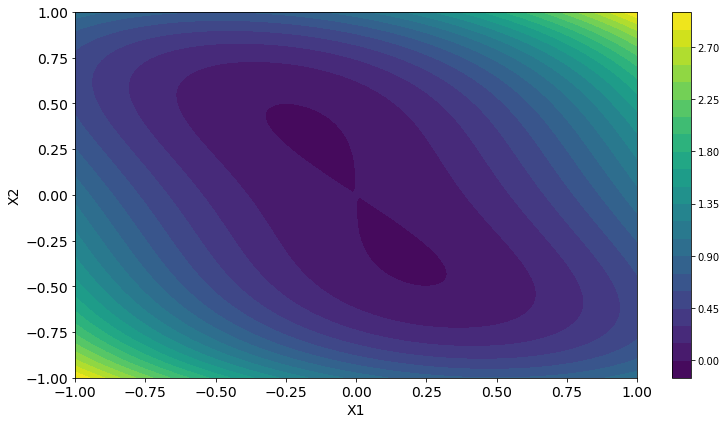

In [5]:
# Нарисуем график этой функции
plot_2d_function(f, N=100, x1_range=[-1., 1.], x2_range=[-1., 1.])
plt.tight_layout()
plt.show()

## Алгоритм градиентного спуска (GD)

In [6]:
def gradient_descent(f, grad, x_0, alpha=0.1, verbose=0, steepest=0):
    
    # Задаем начальную точку
    x_curr = x_0
    # Задаем список x на каждой итерации
    x_iters = [x_curr]
    
    # Запускаем алгоритм оптимизации
    for i in range(1, n_iters):
        
        if verbose: print('Iteration: ', i)
        if verbose: print ('Current x: ', x_curr)
        
        # Считаем градиент в текущей точке
        g = grad(x_curr)
        if verbose: print('Gradient: ', g)
        
        # Если найскорейший спуск
        if steepest:
            best_alpha = alpha_search(f, x_curr, g)
            alpha = best_alpha
        
        # Делаем шаг по направлению антиградиента
        x_new = x_curr - alpha * g
        if verbose: print('New x: ', x_new, '\n')
        
        # Сохраняем новое значение x
        x_iters.append(x_new)
        x_curr = x_new
    
    return np.array(x_iters)

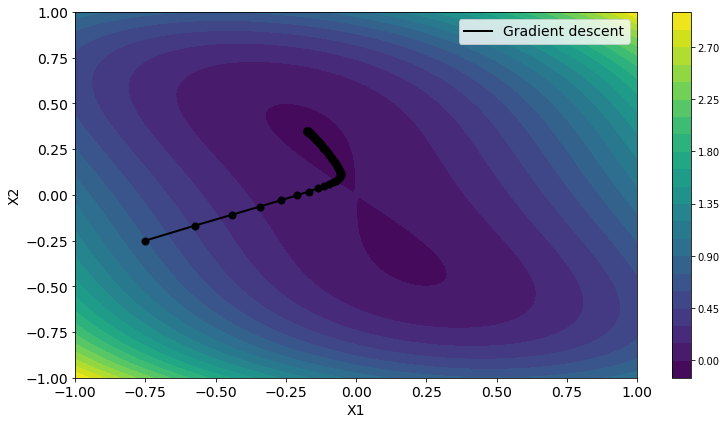

In [7]:
# Параметры алгоритма
n_iters = 100
alpha = 0.1

# Начальная точка оптимизации
x_0 = np.array([[-0.75], [-0.25]])

# Запускаем оптимизацию функции
x_iters = gradient_descent(f, grad, x_0, alpha, verbose=0, steepest=0)

# Строим функцию и путь оптимизации
plot_2d_function(f, N=100, x1_range=[-1., 1.], x2_range=[-1., 1.])        # Строим функцию
add_opt_path(x_iters, label="Gradient descent", color="0", scatter=1)     # Строим путь оптимизации
plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.show()

## Алгоритм SR1

In [8]:
def sr1(f, grad, x_0, alpha=0.1, verbose=0, steepest=1):
    
    # Задаем начальные условия
    B_curr = np.identity(2)
    H_curr = np.linalg.inv(B_curr)
    x_curr = x_0
    x_new  = x_curr - alpha * grad(x_curr)
    s_curr = x_new - x_curr
    y_curr = grad(x_new) - grad(x_curr)

    # Список для хранения промежуточных x
    x_iters_sr1 = [x_0]
    
    # Начинаем оптимизацию
    for i in range(1, n_iters):
        
        if verbose: print('Iteration: ', i)
        if verbose: print ('Current x: ', x_curr)
            
        # Делаем шаг оптимизации
        g = grad(x_curr)
        p = H_curr.dot(g)
        if steepest: alpha = alpha_search(f, x_curr, p)
        x_new = x_curr - alpha * p
        if verbose: print('New x: ', x_new, '\n')
            
        # Обновляем s и y
        s_new = x_new - x_curr
        y_new = grad(x_new) - grad(x_curr)
        s_curr = s_new
        y_curr = y_new

        # Обновляем матрицу B
        b = y_curr - B_curr.dot(s_curr)
        B_new = B_curr + b.dot(b.T) / (b.T.dot(s_curr) + 10**-8)
        
        # Обновляем матрицу H (обратную к B)
        a = s_curr - H_curr.dot(y_curr)
        H_new = H_curr + a.dot(a.T) / (a.T.dot(y_curr) + 10**-8)

        # Считаем критерий обновления матриц B и H
        r = 10**-8
        if s_curr.T.dot(b) > r * np.sqrt(s_curr.T.dot(s_curr) * b.T.dot(b)):
            if verbose: print('Update')
            H_curr = H_new
            B_curr = B_new
        #H_curr = H_new
        #B_curr = B_new

        # Сохраняем промежуточные результаты
        x_iters_sr1.append(x_new)
        x_curr = x_new
    
    return np.array(x_iters_sr1)

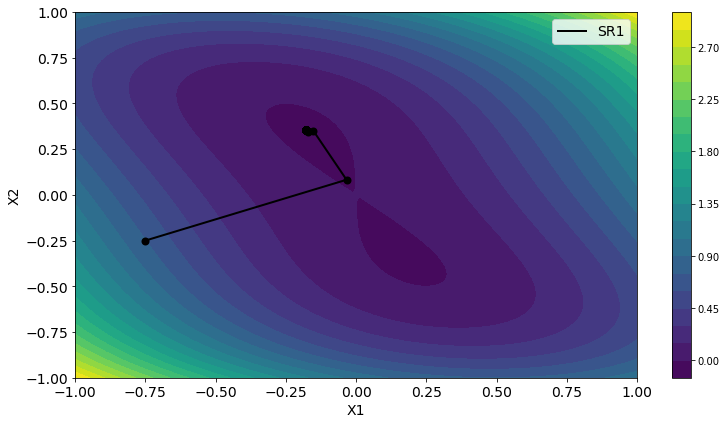

In [9]:
# Параметры алгоритма
n_iters = 100
alpha = 0.1

# Начальная точка оптимизации
x_0 = np.array([[-0.75], [-0.25]])

# Запускаем оптимизацию функции
x_iters_sr1 = sr1(f, grad, x_0, alpha, verbose=0, steepest=1)

# Строим функцию и путь оптимизации
plot_2d_function(f, N=100, x1_range=[-1., 1.], x2_range=[-1., 1.])        # Строим функцию
add_opt_path(x_iters_sr1, label="SR1", color="0", scatter=1)     # Строим путь оптимизации
plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.show()

##  Алгоритм BFGS

In [10]:
def bfgs(f, grad, x_0, alpha=0.1, verbose=0, steepest=1):

    # Задаем начальные условия
    H_curr = np.identity(2)
    x_curr = x_0
    x_new  = x_curr - alpha * grad(x_curr)
    s_curr = x_new - x_curr
    y_curr = grad(x_new) - grad(x_curr)

    # Список для хранения промежуточных x
    x_iters_bfgs = [x_0]
    
    # Начинаем оптимизацию
    for i in range(1, n_iters):
        
        if verbose: print('Iteration: ', i)
        if verbose: print ('Current x: ', x_curr)

        # Делаем шаг оптимизации
        g = grad(x_curr)
        p = H_curr.dot(g)
        if steepest: alpha = alpha_search(f, x_curr, p)
        x_new = x_curr - alpha * p
        if verbose: print('New x: ', x_new, '\n')

        # Обновляем s и y
        s_new = x_new - x_curr
        y_new = grad(x_new) - grad(x_curr)
        s_curr = s_new
        y_curr = y_new
        
        # Обновляем матрицу H
        pho = 1. / (y_curr.T.dot(s_curr) + 10**-8)
        a = np.identity(2) - pho * s_curr.dot(y_curr.T)
        b = np.identity(2) - pho * y_curr.dot(s_curr.T)
        H_new = a.dot( H_curr.dot(b) ) + pho * s_curr.dot(s_curr.T)
        H_curr = H_new

        # Сохраняем промежуточные результаты
        x_iters_bfgs.append(x_new)
        x_curr = x_new
    
    return np.array(x_iters_bfgs)

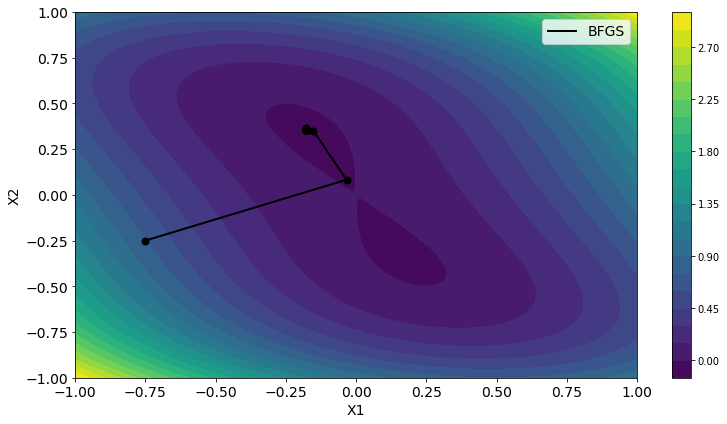

In [11]:
# Параметры алгоритма
n_iters = 100
alpha = 0.1

# Начальная точка оптимизации
x_0 = np.array([[-0.75], [-0.25]])

# Запускаем оптимизацию функции
x_iters_bfgs = bfgs(f, grad, x_0, alpha, verbose=0, steepest=1)

# Строим функцию и путь оптимизации
plot_2d_function(f, N=100, x1_range=[-1., 1.], x2_range=[-1., 1.])        # Строим функцию
add_opt_path(x_iters_bfgs, label="BFGS", color="0", scatter=1)            # Строим путь оптимизации
plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.show()

## Сравнение алгоритмов

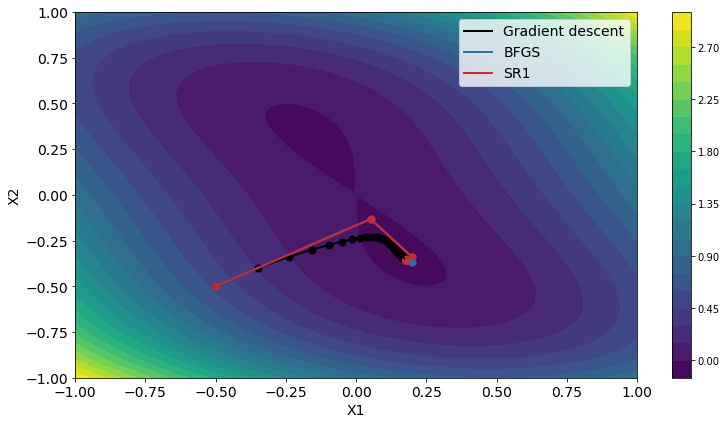

In [12]:
# Параметры алгоритмов
n_iters = 200
alpha = 0.1

# Начальная точка оптимизации
x_0 = np.array([[-0.5], [-0.5]])

# Запускаем оптимизацию функции
x_iters = gradient_descent(f, grad, x_0, alpha, verbose=0, steepest=0)
x_iters_sr1 = sr1(f, grad, x_0, alpha, verbose=0, steepest=1)
x_iters_bfgs = bfgs(f, grad, x_0, alpha, verbose=0, steepest=1)


# Строим функцию и пути оптимизации
plot_2d_function(f, N=100, x1_range=[-1., 1.], x2_range=[-1., 1.])
add_opt_path(x_iters, label="Gradient descent", color="0")
add_opt_path(x_iters_bfgs, label="BFGS", color="C0")
add_opt_path(x_iters_sr1, label="SR1", color="C3")

plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
def dist2opt(x_iters, x_opt):
    diffs = (x_iters - x_opt).reshape(-1, 2)
    diffs2 = diffs**2
    dist = np.sqrt(diffs2.sum(axis=1))
    return dist

In [14]:
dist      = dist2opt(x_iters, x_iters[-1])
dist_sr1  = dist2opt(x_iters_sr1, x_iters_sr1[-1])
dist_bfgs = dist2opt(x_iters_bfgs, x_iters_bfgs[-1])

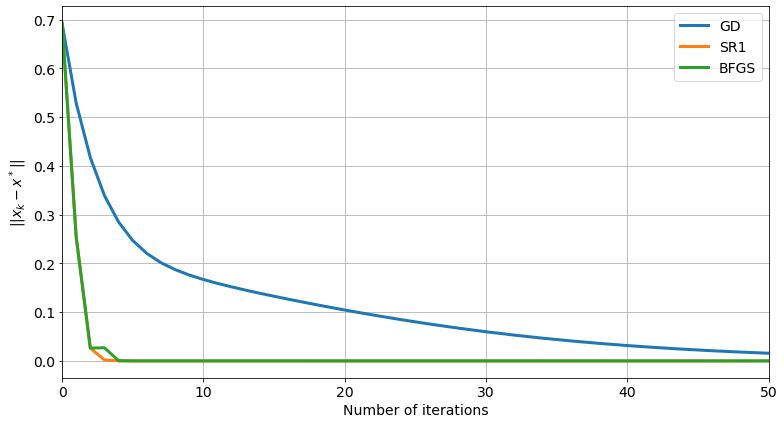

In [15]:
plt.figure(figsize=(11, 6))

plt.plot(dist,      linewidth=3, label='GD')
plt.plot(dist_sr1,  linewidth=3, label="SR1")
plt.plot(dist_bfgs, linewidth=3, label='BFGS')

plt.xlabel('Number of iterations', size=14)
plt.xticks(size=14)
plt.ylabel(r'$|| x_k - x^*||$', size=14)
plt.yticks(size=14)
plt.xlim(0, 50)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.tight_layout()
plt.show()

In [16]:
def ratio(dist):
    r = dist[1:] / (dist[:-1] + 10**-8)
    return r

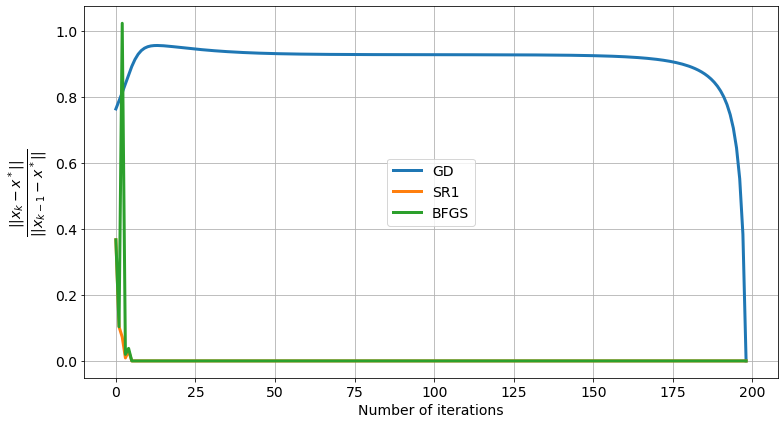

In [17]:
plt.figure(figsize=(11, 6))

plt.plot(ratio(dist),      linewidth=3, label='GD')
plt.plot(ratio(dist_sr1),  linewidth=3, label="SR1")
plt.plot(ratio(dist_bfgs), linewidth=3, label='BFGS')

plt.xlabel('Number of iterations', size=14)
plt.xticks(size=14)
plt.ylabel(r'$\frac{|| x_k - x^*||}{|| x_{k-1} - x^*||}$', size=20)
plt.yticks(size=14)
#plt.xlim(0, 50)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.tight_layout()
plt.show()